<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/PytorchBasics/blob/main/15_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

#from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initialization

In [3]:
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
#Path
#Download the data from here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>_ and extract it to the current directory.
data_dir = '/content/drive/MyDrive/work/Adaptive Control Systems and AI Methods/hymenoptera_data'
save_dir = '/content/drive/MyDrive/work/Adaptive Control Systems and AI Methods'
file_name = 'model.pth'
dict_name = 'model_dict.pth'

In [5]:
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.255])

In [6]:
num_classes = 2
num_epochs = 3
batch_size = 4

lr = 0.001
step_size=7
gamma=0.1

PATH = './cnn.pth'

# Create data sets and data loaders

In [7]:
data_transforms = {
    'train': transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)]),
     'val': transforms.Compose(
         [transforms.Resize(256),
          transforms.RandomCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)])
}

In [8]:
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                  for x in ['train', 'val']}

In [9]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)


['ants', 'bees']


In [10]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [11]:
inputs, classes = next(iter(dataloaders['train']))

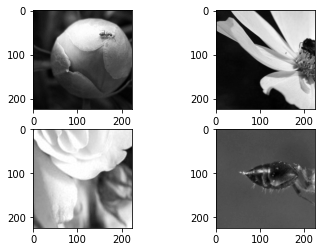

In [12]:
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(inputs[i][0], cmap = 'gray')

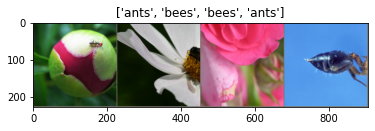

In [13]:
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range (num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' *10)

    #Each epoch has a training and validation phase
    for phase in ['train','val']:
      if phase == 'train':
         model.train()# set model to training mode
      else:
         model.eval() # set model evaluate mode
      
      running_loss = 0.0
      running_corrects = 0.0

      # Iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #forward
        #track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          #backward
          #track history
          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #statistics
        running_loss += loss.item()*inputs.size(0)   
        running_corrects += torch.sum(preds == labels.data)
    
    if phase == 'train':
      scheduler.step()

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print('{} Loss: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    #deep copy the model
    if phase == 'val' and epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  #load best model weights
  model.load_state_dict(best_model_wts)
  return model

# Model

In [15]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
  
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, 
                                        step_size=step_size, gamma=gamma)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# Training

In [16]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=num_epochs)

Epoch 0/2
----------
val Loss: 0.6108

Epoch 1/2
----------
val Loss: 0.4737

Epoch 2/2
----------
val Loss: 0.4010

Training complete in 3m 47s
Best val Acc: 0.843137


# Save and download 

The first option

In [19]:
torch.save(model,file_name)

In [20]:
cd

/root


In [ ]:
model_saved = torch.load('/content/'+str(file_name))
model_saved.eval()

In [ ]:
for param in model_saved.parameters():
  print(param)

The second option

In [35]:
path_dict = '/content/'+str(dict_name)
torch.save(model.state_dict(),path_dict)

In [ ]:
model_new = models.resnet18(pretrained=True)
model_new.fc = nn.Linear(num_ftrs, num_classes)

model_new.load_state_dict(torch.load('/content/'+str(dict_name)))
model_new.eval()

In [38]:
(num_ftrs, num_classes)

(512, 2)

In [ ]:
print(model_new.state_dict())